<a href="https://colab.research.google.com/github/ReeginaTyagi/Sentiment-Analysis_of_Customer-Reviews_for_Cosmetic-Brands/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install google-play-scraper
!pip install fuzzywuzzy python-Levenshtein

In [10]:
from google_play_scraper import app
import pandas as pd
import numpy as np
from google_play_scraper import Sort, reviews_all
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import process
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

**SCRAPING GOOGLE PLAYSTORE REVIEWS**

Enter the name of the brand Mamaearth, SugarCosmetics, Plum, MCaffeine, Pilgrim, MyGlamm, Juicy Chemistry: MCAFFEINE
Enter the date since (YYYY-MM-DD): 2023-03-01
Average Sentiment for MCaffeine: 0.36815968633863405


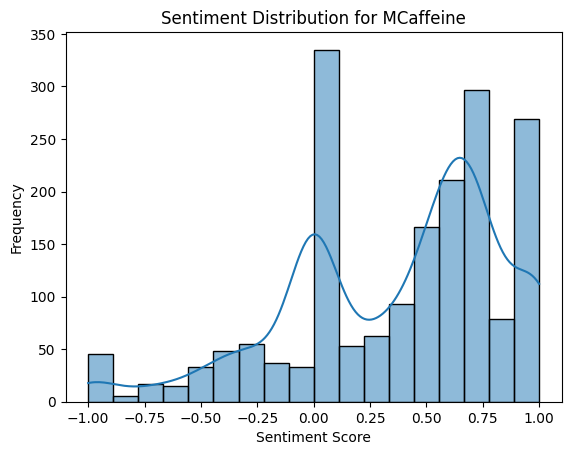

reviewId                  0
userName                  0
userImage                 0
content                   0
score                     0
thumbsUpCount             0
reviewCreatedVersion    141
at                        0
replyContent            856
repliedAt               856
appVersion              141
sentiment                 0
dtype: int64
reviewId                 0.000000
userName                 0.000000
userImage                0.000000
content                  0.000000
score                    0.000000
thumbsUpCount            0.000000
reviewCreatedVersion     7.605178
at                       0.000000
replyContent            46.170442
repliedAt               46.170442
appVersion               7.605178
sentiment                0.000000
dtype: float64


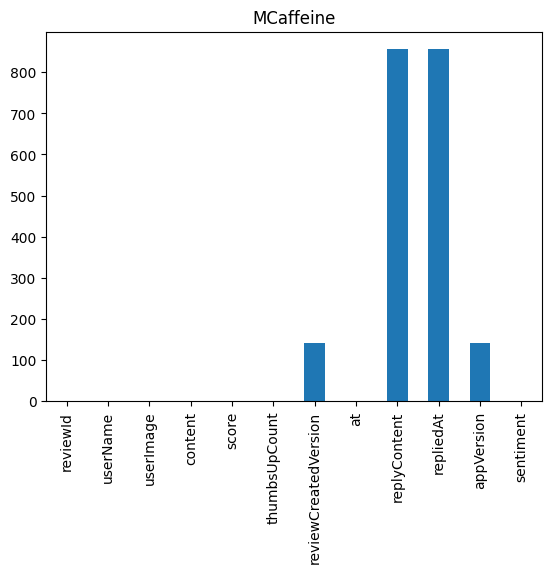

In [94]:
# Define known brand names and their corresponding app links
app_links = {
    'Sugar Cosmetics': 'com.app.sugarcosmetics',
    'Mamaearth': 'com.mamaearthapp',
    'MyGlamm': 'com.myglamm.ecommerce',
    'Juicy Chemistry': 'com.juicychemistry',
    'Plum': 'com.esmagico.plum',
    'MCaffeine': 'com.coffye.mcaffeine',
    'Pilgrim': 'com.discoverpilgrim'
}

def get_closest_brand(input_brand):
    match = process.extractOne(input_brand, app_links.keys())
    return match[0] if match else None

def get_reviews(app_link):
    # Fetch the reviews
    reviews = reviews_all(
        app_link,
        sleep_milliseconds=0,
        lang='en',
        country='in',
        sort=Sort.NEWEST
    )

    # Convert the reviews to a DataFrame
    data = pd.DataFrame(np.array(reviews), columns=['review'])
    data = data.join(pd.DataFrame(data.pop('review').tolist()))
    data_non_string = data[~data['content'].apply(lambda x: isinstance(x, str))]

    return data

def preprocess_data(data, brand_name, data_since):

    data.isna().sum().plot(kind="bar");
    plt.title(f'{brand_name}')
    missing_values_sum = data.isna().sum()
    missing_values_percent = data.isna().mean()*100
    print(missing_values_sum)
    print(missing_values_percent)

    data.drop(columns=['userImage','reviewCreatedVersion','repliedAt', 'appVersion'], inplace=True)
    data['at'] = pd.to_datetime(data['at'])
    data['date'] = data['at'].dt.strftime("%Y-%m-%d")
    data.drop(columns=['at'], inplace=True)
    data['date'] = pd.to_datetime(data['date'])

    data = data[data['date'] >= data_since]
    data = data.drop_duplicates(['content'])
    data['userName_lower'] = data['userName'].str.lower()
    google_users = data[data['userName_lower'] == 'google user']
    non_google_users = data[data['userName_lower'] != 'google user'].drop_duplicates(subset=['userName'])
    data = pd.concat([non_google_users, google_users], ignore_index=True)
    data.drop(columns=['userName_lower'], inplace=True)

    return  data

def save_reviews_to_csv(dataframe, csv_filename):
    # Save the DataFrame to a CSV file
    dataframe.to_csv(csv_filename, index=False)

def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

def plot_sentiment_distribution(data, brand_name):
    sns.histplot(data['sentiment'], kde=True)
    plt.title(f'Sentiment Distribution for {brand_name}')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()



# Input brand name
input_brand = input("Enter the name of the brand Mamaearth, SugarCosmetics, Plum, MCaffeine, Pilgrim, MyGlamm, Juicy Chemistry: ").strip().lower()
brand_name = get_closest_brand(input_brand)
data_since = input(str("Enter the date since (YYYY-MM-DD): "))

if brand_name:
    app_link = app_links.get(brand_name)
    csv_filename = f"{brand_name}.csv"

    data = get_reviews(app_link)
    save_reviews_to_csv(data, csv_filename)
    data['sentiment'] = data['content'].apply(calculate_sentiment)
    data_sentiment_avg = data['sentiment'].mean()
    print(f"Average Sentiment for {brand_name}: {data_sentiment_avg}")
    plot_sentiment_distribution(data, brand_name)
    data = preprocess_data(data, brand_name, data_since)

else:
    print(f"Brand '{input_brand}' not found.")



**Pre-Processing**

In [95]:
def proc_feature(features):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', features)
    processed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    processed_feature = processed_feature.lower()
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    processed_feature = regrex_pattern.sub(r'', processed_feature)
    processed_feature = re.sub(r'[^\x00-\x7F]+',' ', processed_feature)
    return processed_feature

def remove_stopwords(text):
    english_stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in english_stop_words]
    return ' '.join(filtered_text)

# Loading slang dictionary
df_slang = pd.read_csv('/content/abbrevations.csv', encoding='latin1')  # Replace with the actual path

# Slang replacement function
def replace_slang(content_clean):
    content_clean = content_clean.lower()
    res = ''
    for item in content_clean.split():
        if item in df_slang.Slang.values:
            res += df_slang[df_slang['Slang'] == item]['formal'].iloc[0]
        else:
            res += item
        res += ' '
    return res


# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment scores
def calculate_sentiment_scores(text):
    scores = sid.polarity_scores(text)
    return scores['compound']

data['content_clean'] = data['content'].apply(lambda x: proc_feature(x))
data['content_clean'] = data['content_clean'].apply(remove_stopwords)
df_slang = pd.read_csv('/content/abbrevations.csv', encoding='latin1')
data['content_clean'] = data['content_clean'].apply(replace_slang)
data['sentiment_score'] = data['content_clean'].apply(calculate_sentiment_scores)
data['sentiment'] = data['sentiment_score'].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
print(data[['content_clean', 'sentiment_score', 'sentiment']])

                                         content_clean  sentiment_score  \
0                                      wrong products           -0.4767   
1                                                good            0.4404   
2    bhot wahiyaat app kuch offer ni mne to baar or...          -0.6369   
3    bad experience customer care support resolutio...           0.8225   
4    ordered products 10 days received yet even pla...           0.0000   
..                                                 ...              ...   
914                                              slow            0.0000   
915                  product good skin bad experience           -0.1531   
916                                varry good product            0.4404   
917                                              nice            0.4215   
918                                      sexy kny cxc            0.5267   

     sentiment  
0           -1  
1            1  
2           -1  
3            1  
4            0

In [96]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Map the sentiment to labels
sentiment_labels = {1: 'Positive', -1: 'Negative', 0: 'Neutral'}
data['sentiment_label'] = data['sentiment'].map(sentiment_labels)

# Group by sentiment label and sum the scores
sent = data.groupby(['sentiment_label'])[['score']].sum().reset_index()

# Sort the values and group smaller values into an "Other" category
sent = sent.sort_values(by='score', ascending=False)
threshold = 0.01 * sent['score'].sum()  # Threshold for grouping small values
small_slices = sent[sent['score'] < threshold]
if not small_slices.empty:
    sent = sent[sent['score'] >= threshold]
    other_row = pd.DataFrame({
        'sentiment_label': ['Other'],
        'score': [small_slices['score'].sum()]
    })
    sent = pd.concat([sent, other_row], ignore_index=True)

# Define custom colors
custom_colors = ['#1F77B4', '#FF7F0E', '#2CA02C']  # Example custom colors

# Plot the pie chart using Plotly Express
fig = px.pie(
    sent,
    values='score',
    names='sentiment_label',
    height=600,
    width=600,
    title=f'Total Sentiment Score {input_brand}',
    color_discrete_sequence=custom_colors
)

# Update layout for better visibility
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    uniformtext_minsize=12,
    uniformtext_mode='hide'
)

# Display the plot
fig.show()

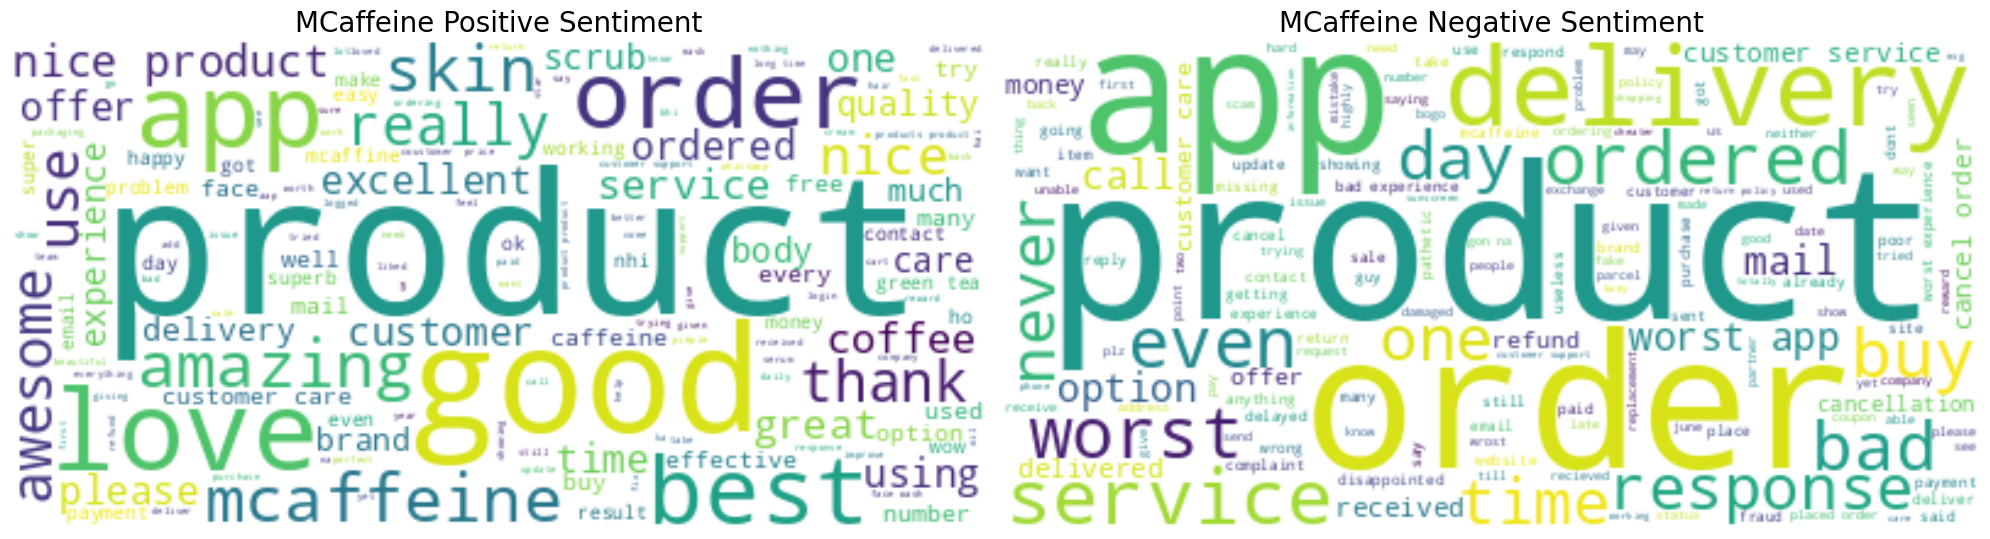

In [97]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Assuming 'data' DataFrame contains the mcaffeine reviews with 'content_clean' and 'sentiment_score' columns

# Define custom stopwords
my_stp = set(STOPWORDS)  # Add any additional stopwords if necessary

# Generate word clouds for negative sentiment of mcaffeine
cc_mcaffeine_neg = data[data['sentiment'] == -1]['content_clean']
if not cc_mcaffeine_neg.empty:
    mcaffeine_neg = WordCloud(
        background_color='white',
        max_words=150,
        stopwords=my_stp,
        random_state=99
    ).generate(' '.join(cc_mcaffeine_neg))

# Generate word clouds for positive sentiment of mcaffeine
cc_mcaffeine_pos = data[data['sentiment'] == 1]['content_clean']
if not cc_mcaffeine_pos.empty:
    mcaffeine_pos = WordCloud(
        background_color='white',
        max_words=150,
        stopwords=my_stp,
        random_state=99
    ).generate(' '.join(cc_mcaffeine_pos))

# Plot the word clouds
plt.figure(figsize=(20, 10))

# mcaffeine positive sentiment word cloud
if not cc_mcaffeine_pos.empty:
    plt.subplot(1, 2, 1)
    plt.imshow(mcaffeine_pos, interpolation='bilinear')
    plt.title('MCaffeine Positive Sentiment', fontsize=20)
    plt.axis('off')

# mcaffeine negative sentiment word cloud
if not cc_mcaffeine_neg.empty:
    plt.subplot(1, 2, 2)
    plt.imshow(mcaffeine_neg, interpolation='bilinear')
    plt.title('MCaffeine Negative Sentiment', fontsize=20)
    plt.axis('off')

# Display the plot
plt.tight_layout()
plt.show()


**MODEL BUILDING**

In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Map sentiment scores to categorical labels
y = data.sentiment.map({-1: 0, 0: 1, 1: 2})
X = data.content_clean

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [99]:
def prepare_targets(y_train, y_test):
	y_train_enc = to_categorical(y_train)
	y_test_enc = to_categorical(y_test)
	return y_train_enc, y_test_enc

y_train, y_test = prepare_targets(y_train, y_test)


In [100]:
to_categorical(y)

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [101]:
# split train-val
train_sentences, val_sentences, train_labels, val_labels = train_test_split(X_train.to_numpy(),
                                                                            y_train,
                                                                            test_size=0.1,
                                                                            random_state=42)


In [102]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization\
# Hitung rata-rata token yang dibentuk dalam satu content
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))


8

In [103]:
# 10 data teratas train sentence
train_sentences[:10], train_labels[:10]


(array(['serum damage aya return bhi nhi lne aye mujhe bahut pareshani hui mera personal experience yhi bolta ki koi bhi se product nhi le ',
        'fev products love ',
        'completely skin friendly safe use daily routine ',
        'app badly designed customer service also good keep saying order cancelled past 5 days seen cancelled neithery money refunded option app update profile details see place cancel order disappointed mcaffeine ',
        'smooth app ', 'versatile products ', 'love ',
        'good app face nd body care ',
        'worst experience ever ordered soap 5 days say ordered cancelled recommend use app ',
        'super app '], dtype=object),
 array([[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]], dtype=float32))

In [104]:
max_vocab_length = 10000
max_length = 13

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=max_length)


In [105]:
text_vectorizer.adapt(train_sentences)

In [106]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length)



**LSTM MODEL**

In [107]:
import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout
keras.backend.clear_session()
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(64, dropout=0.75, recurrent_dropout=0.75)(x)
x = layers.Dense(76)(x)
x = layers.Dropout(0.75)(x)
print(x.shape)
outputs = layers.Dense(3, activation="softmax")(x)
model_LSTM = tf.keras.Model(inputs, outputs, name="model_calcbase_LSTM")


(None, 13, 128)
(None, 76)


In [72]:
model_LSTM.summary()

Model: "model_calcbase_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 13)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 13, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 76)                4940      
                                                                 
 dropout (Dropout)           (None, 76)                0         
                                               

In [108]:
model_LSTM.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [109]:
# Fit model
model_LSTM_history = model_LSTM.fit(train_sentences,
                              train_labels,
                              epochs=50,
                              validation_data=(val_sentences, val_labels))


Epoch 1/50
21/21 [==============================] - 6s 90ms/step - loss: 0.9981 - accuracy: 0.5567 - val_loss: 0.9252 - val_accuracy: 0.5541
Epoch 2/50
21/21 [==============================] - 1s 37ms/step - loss: 0.9247 - accuracy: 0.6006 - val_loss: 0.8729 - val_accuracy: 0.5541
Epoch 3/50
21/21 [==============================] - 1s 43ms/step - loss: 0.8524 - accuracy: 0.6520 - val_loss: 0.7240 - val_accuracy: 0.7162
Epoch 4/50
21/21 [==============================] - 1s 63ms/step - loss: 0.7662 - accuracy: 0.6717 - val_loss: 0.5901 - val_accuracy: 0.7432
Epoch 5/50
21/21 [==============================] - 1s 39ms/step - loss: 0.6371 - accuracy: 0.7322 - val_loss: 0.4561 - val_accuracy: 0.7432
Epoch 6/50
21/21 [==============================] - 1s 34ms/step - loss: 0.4755 - accuracy: 0.7988 - val_loss: 0.2816 - val_accuracy: 0.9324
Epoch 7/50
21/21 [==============================] - 1s 34ms/step - loss: 0.3599 - accuracy: 0.8578 - val_loss: 0.1934 - val_accuracy: 0.9189
Epoch 8/50
21

In [110]:
model_LSTM_pred_probs = model_LSTM.predict(val_sentences)
model_LSTM_pred_probs[:10]


3/3 [==============================] - 0s 5ms/step


array([[6.84759198e-06, 9.99974668e-01, 1.85335866e-05],
       [1.29954625e-09, 3.27787916e-07, 9.99999583e-01],
       [9.99997914e-01, 9.24833046e-08, 1.89412378e-06],
       [9.99913871e-01, 4.52020276e-06, 8.15575913e-05],
       [4.66180444e-01, 4.90781069e-01, 4.30384949e-02],
       [1.78822113e-09, 3.81055941e-07, 9.99999583e-01],
       [1.87291553e-05, 9.99924004e-01, 5.71660712e-05],
       [8.94297808e-02, 7.02697635e-01, 2.07872584e-01],
       [6.96587499e-09, 7.42843554e-07, 9.99999225e-01],
       [9.99946177e-01, 1.18106445e-05, 4.19209573e-05]], dtype=float32)

In [111]:
model_LSTM_pred_probs[:10].argmax(axis=1)


array([1, 2, 0, 0, 1, 2, 1, 1, 2, 0])

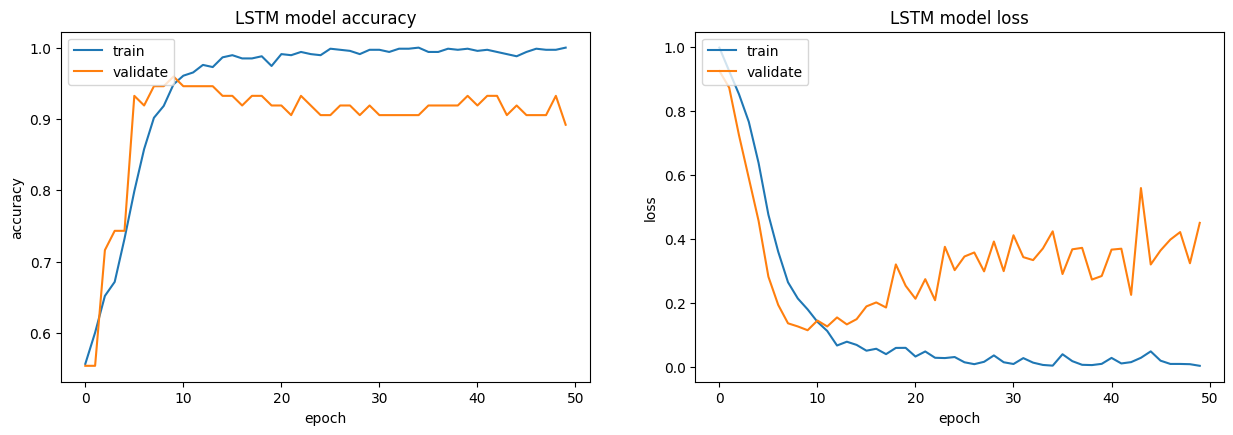

In [112]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(model_LSTM_history.history['accuracy'])
plt.plot(model_LSTM_history.history['val_accuracy'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')


plt.subplot(2, 2,2 )
plt.plot(model_LSTM_history.history['loss'])
plt.plot(model_LSTM_history.history['val_loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')

plt.show()

In [115]:
model_LSTM_pred_probs = model_LSTM.predict(X_test.to_numpy())

# Calculate results
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

y_pred = model_LSTM_pred_probs.argmax(axis=1)
model_LSTM_results = calculate_results(y_true=y_test.argmax(axis=1), y_pred=y_pred)
print(model_LSTM_results)

6/6 [==============================] - 0s 4ms/step
{'accuracy': 88.58695652173914, 'precision': 0.8911908919604186, 'recall': 0.8858695652173914, 'f1': 0.8858914273221654}


**GRU MODEL**

In [116]:
import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout
keras.backend.clear_session()
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.GRU(64, dropout=0.75, recurrent_dropout=0.75)(x)
x = layers.Dense(76)(x)
x = layers.Dropout(0.75)(x)
print(x.shape)
outputs = layers.Dense(3, activation="softmax")(x)
model_GRU = tf.keras.Model(inputs, outputs, name="model_calcbase_GRU")

(None, 13, 128)
(None, 76)


In [117]:
model_GRU.summary()

Model: "model_calcbase_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 13)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 13, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 76)                4940      
                                                                 
 dropout (Dropout)           (None, 76)                0         
                                                

In [118]:
# Compile model
model_GRU.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [119]:
# Fit model
model_GRU_history = model_GRU.fit(train_sentences,
                              train_labels,
                              epochs=50,
                              validation_data=(val_sentences, val_labels))

Epoch 1/50
21/21 [==============================] - 6s 90ms/step - loss: 1.0111 - accuracy: 0.5703 - val_loss: 0.9315 - val_accuracy: 0.5676
Epoch 2/50
21/21 [==============================] - 1s 41ms/step - loss: 0.8935 - accuracy: 0.6415 - val_loss: 0.8787 - val_accuracy: 0.6081
Epoch 3/50
21/21 [==============================] - 1s 66ms/step - loss: 0.7891 - accuracy: 0.7080 - val_loss: 0.6840 - val_accuracy: 0.7027
Epoch 4/50
21/21 [==============================] - 1s 31ms/step - loss: 0.4702 - accuracy: 0.7897 - val_loss: 0.3807 - val_accuracy: 0.7568
Epoch 5/50
21/21 [==============================] - 1s 25ms/step - loss: 0.3395 - accuracy: 0.8245 - val_loss: 0.4149 - val_accuracy: 0.7568
Epoch 6/50
21/21 [==============================] - 1s 25ms/step - loss: 0.2653 - accuracy: 0.9017 - val_loss: 0.2935 - val_accuracy: 0.8919
Epoch 7/50
21/21 [==============================] - 1s 43ms/step - loss: 0.1930 - accuracy: 0.9561 - val_loss: 0.2322 - val_accuracy: 0.9324
Epoch 8/50
21

In [120]:
model_GRU_pred_probs = model_GRU.predict(val_sentences)
model_GRU_pred_probs[:10]

3/3 [==============================] - 1s 9ms/step


array([[9.2988762e-07, 9.9999386e-01, 5.1046704e-06],
       [7.0371577e-11, 1.8964555e-10, 9.9999994e-01],
       [9.9999994e-01, 1.8543361e-08, 2.6728053e-09],
       [9.9999994e-01, 8.1011137e-10, 3.4375433e-10],
       [9.0107000e-01, 9.6303247e-02, 2.6267758e-03],
       [1.1328639e-10, 2.9078331e-10, 9.9999994e-01],
       [2.6511518e-07, 9.9999827e-01, 1.3921904e-06],
       [6.4055197e-04, 9.8991424e-01, 9.4453227e-03],
       [9.7815045e-10, 2.1111757e-09, 9.9999994e-01],
       [9.9999994e-01, 3.0727168e-08, 1.2746317e-10]], dtype=float32)

In [121]:
model_GRU_pred_probs[:10].argmax(axis=1)

array([1, 2, 0, 0, 0, 2, 1, 1, 2, 0])

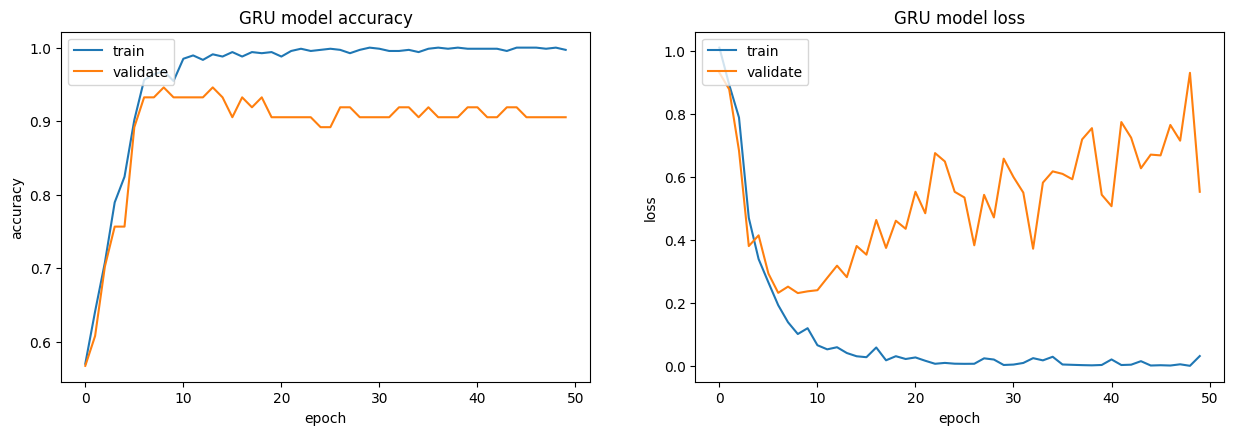

In [122]:
# Plot accuracy training dan validation set
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(model_GRU_history.history['accuracy'])
plt.plot(model_GRU_history.history['val_accuracy'])
plt.title('GRU model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')


plt.subplot(2, 2,2 )
plt.plot(model_GRU_history.history['loss'])
plt.plot(model_GRU_history.history['val_loss'])
plt.title('GRU model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')

plt.show()

In [129]:
model_GRU_pred_probs = model_GRU.predict(X_test.to_numpy())

# Calculate results
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

y_pred = model_GRU_pred_probs.argmax(axis=1)
model_GRU_results = calculate_results(y_true=y_test.argmax(axis=1), y_pred=y_pred)
print(model_GRU_results)

6/6 [==============================] - 0s 6ms/step
{'accuracy': 90.76086956521739, 'precision': 0.9131551380746208, 'recall': 0.907608695652174, 'f1': 0.9086784452755702}
